<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/End_to_End_Deep_Learning_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Deep Learning

## Setup

In [ ]:
import os
import sys
import PIL
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Concatenate, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "DatasetV4")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
library_dir = os.path.join(base_dir, "Library")

sys.path.append(library_dir)
from utils import FeatureExtractor
from cf_matrix import make_confusion_matrix

## Load the Pre-trained Model

In [ ]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
model = hub.load(module_handle)
model.signatures.keys()
detector = model.signatures["default"]

## Load the Dataset

In [ ]:
image_size = (300, 300)
class_names = ["Blur", "Bokeh", "Normal"]

train_dir = os.path.join(data_dir, "train")
validation_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse"
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse"
)

Found 1771 images belonging to 3 classes.
Found 328 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [ ]:
run_extractor = True

if run_extractor:
    feature_extractor = FeatureExtractor(detector, image_denormalization=True)

    X_train, y_train = next(train_generator)
    X_train_pre = feature_extractor(X_train)
    X_val, y_val = next(validation_generator)
    X_val_pre = feature_extractor(X_val)
    X_test, y_test = next(test_generator)
    X_test_pre = feature_extractor(X_test)

    np.save(os.path.join(serialized_data_dir, "X_train.npy"), X_train)
    np.save(os.path.join(serialized_data_dir, "y_train.npy"), y_train)
    np.save(os.path.join(serialized_data_dir, "X_val.npy"),   X_val)
    np.save(os.path.join(serialized_data_dir, "y_val.npy"),   y_val)
    np.save(os.path.join(serialized_data_dir, "X_test.npy"),  X_test)
    np.save(os.path.join(serialized_data_dir, "y_test.npy"),  y_test)
    np.save(os.path.join(serialized_data_dir, "X_train_pre.npy"), X_train_pre.numpy())
    np.save(os.path.join(serialized_data_dir, "X_val_pre.npy"),   X_val_pre.numpy())
    np.save(os.path.join(serialized_data_dir, "X_test_pre.npy"),  X_test_pre.numpy())

else:
    X_train = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_train.npy")))
    y_train = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "y_train.npy")))
    X_val = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_val.npy")))
    y_val = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "y_val.npy")))
    X_test = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_test.npy")))
    y_test = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "y_test.npy")))
    X_train_pre = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_train_pre.npy")))
    X_val_pre = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_val_pre.npy")))
    X_test_pre = tf.convert_to_tensor(np.load(os.path.join(serialized_data_dir, "X_test_pre.npy")))

## Build the Model

In [ ]:
input_layer_1 = Input(shape=[2])
input_layer_2 = Input(shape=(image_size + (3,)))

hidden_layer_1 = Dense(32, activation="relu")(input_layer_1)
hidden_layer_1 = Dense(64, activation="relu")(hidden_layer_1)
hidden_layer_1 = Dense(128, activation="relu")(hidden_layer_1)

conv_layer = Conv2D(32, 5, activation="relu")(input_layer_2)
pool_layer = MaxPool2D(2, 2)(conv_layer)
conv_layer = Conv2D(64, 3, activation="relu")(pool_layer)
pool_layer = MaxPool2D(2, 2)(conv_layer)
conv_layer = Conv2D(64, 3, activation="relu")(pool_layer)
pool_layer = MaxPool2D(2, 2)(conv_layer)
conv_layer = Conv2D(64, 3, activation="relu")(pool_layer)
pool_layer = MaxPool2D(2, 2)(conv_layer)
conv_layer = Conv2D(64, 3, activation="relu")(pool_layer)
pool_layer = MaxPool2D(2, 2)(conv_layer)
flatten_layer = Flatten()(pool_layer)
# flatten_layer = Dropout(0.2)(flatten_layer)
hidden_layer_2 = Dense(128, activation="relu")(flatten_layer)

concat_layer = Concatenate()([hidden_layer_1, hidden_layer_2])
output_layer = Dense(3, activation="softmax")(concat_layer)

model = Model(inputs=[input_layer_1, input_layer_2], outputs=output_layer)

model.compile(loss="sparse_categorical_crossentropy", optimizer=RMSprop(learning_rate=1e-5), metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 296, 296, 32)         2432      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 146, 146, 64)         18496     ['max_pooling2d[0][0]']   

## Train, Evaluate, and Save the Model

In [ ]:
history = model.fit(
    [X_train_pre, X_train],
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=([X_val_pre, X_val], y_val),
)

Epoch 1/50
56/56 [==============================] - 7s 97ms/step - loss: 1.0996 - accuracy: 0.2891 - val_loss: 1.0973 - val_accuracy: 0.2957
Epoch 2/50
56/56 [==============================] - 5s 88ms/step - loss: 1.0958 - accuracy: 0.3676 - val_loss: 1.0948 - val_accuracy: 0.4329
Epoch 3/50
56/56 [==============================] - 5s 86ms/step - loss: 1.0937 - accuracy: 0.4082 - val_loss: 1.0930 - val_accuracy: 0.4085
Epoch 4/50
56/56 [==============================] - 5s 92ms/step - loss: 1.0927 - accuracy: 0.4116 - val_loss: 1.0914 - val_accuracy: 0.4085
Epoch 5/50
56/56 [==============================] - 5s 88ms/step - loss: 1.0910 - accuracy: 0.4088 - val_loss: 1.0902 - val_accuracy: 0.4085
Epoch 6/50
56/56 [==============================] - 5s 91ms/step - loss: 1.0896 - accuracy: 0.4088 - val_loss: 1.0890 - val_accuracy: 0.4085
Epoch 7/50
56/56 [==============================] - 5s 97ms/step - loss: 1.0887 - accuracy: 0.4082 - val_loss: 1.0879 - val_accuracy: 0.4085
Epoch 8/50
56

In [ ]:
model.evaluate([X_test_pre, X_test], y_test)

4/4 [==============================] - 0s 26ms/step - loss: 0.7432 - accuracy: 0.6579


[0.7431973218917847, 0.6578947305679321]

In [ ]:
model_weights_filename = "End-to-End Deep Learning Model.h5"
model.save_weights(os.path.join(serialized_data_dir, model_weights_filename))

## Confusion Matrix

4/4 [==============================] - 0s 31ms/step


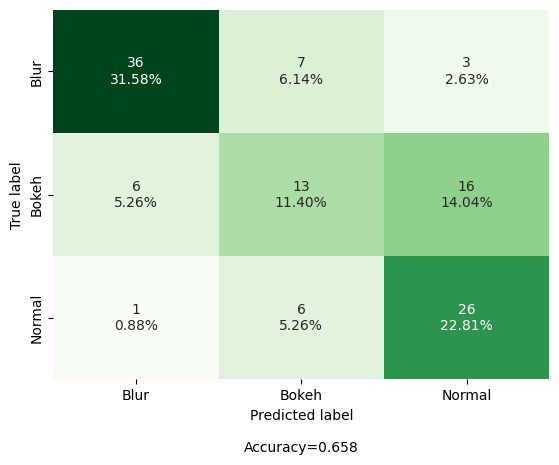

In [ ]:
test_pred = model.predict([X_test_pre, X_test])
test_pred = tf.argmax(test_pred, axis=1)
cm = confusion_matrix(y_test, test_pred)
make_confusion_matrix(cm, categories=class_names, cmap="Greens", cbar=False)

## Load the Model

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, model_weights_filename))